### Constants and ModelInfo

In [1069]:
"""This program trains a sentiment analyis model (logistic regression or SVM)
using TFIDF features. It stores the model, along with some information from
its training and some metrics, in the "models" folder of this project's
directory. There are functions to preprocess text, extract features, train the
model, and to save them to a file.
"""
# For interfacing with Twitter
import tweepy as tp

# Modules for saving objects.
import pickle
import joblib
from matplotlib.pyplot import savefig, show
import os

# These are used for reading training data.
import csv

# These are some modules used for preprocessing.
from contractions import fix
import re
from unidecode import unidecode
from nltk.stem.porter import PorterStemmer

# These modules is for extracting features from the data.
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import csr_matrix

# These modules are for training the ML model.
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from datetime import datetime
def now(format='str'):      # Used by model timelog
    if format == 'str': return datetime.now().strftime(r'%H:%M:%S.%f')
    elif format == 'datetime': return datetime.now()
    

#These modules are used for measuring the model's performance.
import sklearn
import pandas as pd

STOPWORDS = [
    'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an',
    'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been',
    'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't",
    'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't",
    'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from',
    'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having',
    'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself',
    'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've",
    'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's",
    'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of',
    'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours',
    'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd",
    "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than',
    'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then',
    'there', "there's", 'these', 'they', "they'd", "they'll", "they're",
    "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up',
    'very', 'was', "wasn't", 'we', "we'd", "we'll", "we're", "we've", 'were',
    "weren't", 'what', "what's", 'when', "when's", 'where', "where's", 'which',
    'while', 'who', "who's", 'whom', 'why', "why's", 'with', "won't", 'would',
    "wouldn't", 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours',
    'yourself', 'yourselves'
    ]

class ModelInfo(object):
    """A bunch of information about the current model, to be used in naming
    files and folders to be saved with it. Its attributes are the corpus, its
    size, the vectorizer used, the datetime training happened, and a
    dictionary of all of that in a string format already."""
    def __init__(
            self, corpus, vectorizer, model=None,
            log=None, time: datetime = now('datetime')
            ):
        self.corpus: list[tuple[str, int]] = corpus
        self.size: int = len(self.corpus)
        self.vectorizer: CountVectorizer | TfidfVectorizer = vectorizer
        self.model: LogisticRegression | SVC | None = model
        self.time = time
        self.log = log

        if type(self.vectorizer) == CountVectorizer:
            vectype = "Bag of Words"
        elif type(self.vectorizer) == TfidfVectorizer:
            vectype = "TFIDF"
        else: vectype = "Unknown"
        
        if type(self.model) == LogisticRegression:
            modeltype = "Logistic Regression"
        elif type(self.model) == SVC:
            modeltype = "SVM"
        else: modeltype = "Unknown"
        
        self.string_dict = {
            'size': str(self.size),
            'vectorizer': vectype,
            'model': modeltype,
            'time': self.time.strftime(r'%m-%d-%Y--%H-%M-%S'),
            'log': self.log
            }

In [1070]:
# Stick to joblib for both saving and loading for stability.

def save_object(object, path: str, serializer=joblib) -> None:
    """Saves an object to a specified path. It can take corpuses as lists of
    tuples to save as .csv, strings to save as .txt, ConfusionMatrixDisplay
    objects to save as .png, and other objects to save as .pkl.
    \n
    Items should be saved under a common directory in Models for the
    particular model that includes the corpus it was trained on, the
    vectorizer, the preprocessing code, and any testing data.
    \n
    It might have broken calls of name save().
    """
    
    # At least the string-saving block can't open a file in a
    # not-yet-extant directory.
    directory = os.path.dirname(path)
    if not os.path.exists(directory): os.mkdir(directory)

    # Saves ConfusionMatrixDisplay from testing as .png
    if type(object) == sklearn.metrics.ConfusionMatrixDisplay:
        object.plot()
        savefig(path, format='png')

    # Saves a string (.txt, .html, .py, etc.).
    elif type(object) == str:
        with open(path, 'w') as f:
            f.write(object)

    # Makes a headerless, indexless .csv from a corpus in the form of
    # list[tuple(document, label)]. The .csv is (document, label)
    elif type(object) == list:
        # Ensuring that the list is of tuples and not just documents
        if type(object[0]) == tuple:
            docs = list(i[0] for i in object)
            labels = list(i[1] for i in object)
            df = pd.DataFrame({'Documents': docs, 'Labels': labels})
            df.to_csv(path, header=False, index=False)
        else: raise Exception('Corpus must be a list of tuples.')
    
    # In this case I'm serializing a fitted bytes vectorizer or model.
    else:   
        if serializer == joblib:
            joblib.dump(object, path)
        elif serializer == pickle:
            with open(path, 'wb') as f:     # It's a binary file, not text.
                pickle.dump(object, f)
        else: raise Exception("Serializer must be joblib or pickle.")



def load_object(path, serializer=joblib):
    """Loads a serialized (vectorizer or model) object.
    """
    if serializer == joblib:
            thing = joblib.load(path)
    elif serializer == pickle:
        with open(path, 'rb') as f:     # It's a binary file, not text.
            thing = pickle.load(f)
    else: raise Exception("Serializer must be joblib or pickle.")
    return thing

In [1071]:
def get_tweets(
        username, max_results = 5,
        includingRetweets = False, includingReplies = True
        ) -> tuple[str, str]:
    """Takes a username, a number of results to fetch, and booleans that
    indicate whether or not to include retweets and replies, and returns a
    list of (tweet, id) tuples.
    """
    bearer_token = "redacted"
    # These all seem to be unnecessary.
    client_ID = "redacted"
    client_secret = "-redacted"
    redirect_uri = "redacted"
    consumer_key = "redacted"
    consumer_secret = "redacted"
    access_token = "redacted"
    access_token_secret = "redacted"

    client = tp.Client(bearer_token=bearer_token)
    ID = client.get_user(username=username).data.id


    def choose_exclusions(rt, rp):
        """Makes a list of things to exclude from get_users_tweets. If
        nothing, returns None instead of an empty list because tweepy does
        not like the empty list."""
        lst = []
        if not rt:
            lst.append('retweets')
        if not rp:
            lst.append('replies')
        if len(lst) == 0: lst = None
        return lst

    tweets = client.get_users_tweets(
        id=ID, max_results=max_results,
        exclude=choose_exclusions(includingRetweets, includingReplies)
        )
    
    temp = []
    for i in range(len(tweets.data)):
        temp.append((tweets.data[i].text, tweets.data[i].id))
    
    tweet_list = temp
    return tweet_list

In [1072]:
def get_corpus(
        fp=None, size: int = 100, cols: tuple[int, int] = (1,1,),
        *, skippedlines=0
        ):
    """Broken csv reading function that I ended up specializing to the
    training.1600000.processed.noemoticon.csv. The filepath is hard-set to
    the variable fp set within the function. Same with the cols. Access list
    of documents using (p[0] for p in corpus) and list of labels using (p[1]
    for p in corpus).
    \n
    skippedlines is the number of rows in the .csv before the new label.
    """
    if size  % 2 != 0:
        raise Exception('size must be an even integer to get corpus')
    
    # Path to the default corpus .csv and its parameters
    if fp == None:
        fp = r'Data\training.1600000.processed.noemoticon.csv'
        cols = (5, 0)
        skippedlines = 800000

    # Stuck to the columns that this dataset used
    cols = (5, 0)
    
    # Get corpus by making two dataframes of given size and concatenating.
    df1 = pd.read_csv(
        fp, usecols=cols, names=('Label', 'Document'), nrows=size/2,
        encoding='latin-1')
    df2 = pd.read_csv(
        fp, usecols=cols, names=('Label', 'Document'), nrows=size/2,
        skiprows=skippedlines, encoding='latin-1')
    df = pd.concat([df1, df2])
    df = df[df.Label != 2]

    display(df)
    # Split into lists of documents and labels with matching indices.
    docs = list(i for i in df.Document)
    labels = list(i for i in df.Label)
    
    # Fill a list up with tuples with the document and its matching labels.
    temp = []
    for i in range(len(df.index)):
        temp.append((docs[i], labels[i]))
    return temp


revision_comment_ = """
    The counter concept would eliminate the need for a skippedlines parameter.
    The following code illustrates it.

    with open(fp, 'r', newline='', encoding='latin-1') as f:
        reader = csv.reader(f)
        print('file read')
        temp = []
        # Do this with a while loop or a for and conditional break
        
        
        
        counter = 0
        for i in reader:
            if counter == size / 2:
                break
            else:
                if str(i[cols[1]]) == str(sought_labels[1]):
                    temp.append((i[cols[0]], i[cols[1]]))
                    print('label 2')
            counter += 1
            
        
        counter = 0
        for i in reader:
            if counter == size / 2:
                break
            else:
                if str(i[cols[1]]) == str(sought_labels[0]):
                    temp.append((i[cols[0]], i[cols[1]]))
                    print('label 1')
            counter += 1
            

    return 
    """

In [1073]:
def preprocess(texts: list) -> list:
    """Takes in a list (corpus) of strings and returns a list of the processed
    versions of the strings.
    """
    temp = []   # A list that will fill with processed documents.
    for s in texts:
        
        # Normalize diacritics, contractions, and slang.
        # The use of contractions and slang could be important, so maybe don't
        # use contractions.fix, and make the unidecode slang argument False.
        # However, if contractions are used, you might need to add various
        # apostrophe forms to the last substitution filter: re.sub('[^'...
        s = fix(unidecode(s))
        
        # Remove the links and @mentions with regular expression substitutions.
        s = re.sub(r'@\w+', '', s)    # Removes @users (\w is a-Z, 0-9, _).
        s = re.sub(r'http\S+', '', s)
        s = re.sub(r'www\.\S+', '', s)    # Removes links.
        s = re.sub(r'\s+', ' ', s)  # Removes extra spaces
        s = re.sub(r'[^\w\s#]', '', s)    # Removes all but abc123... and '#'.

        # Stem the words. PorterStemmer.stem() also makes lowercase.
        stemmer = PorterStemmer()
        stemmed_words = []      # A list that will fill with stemmed words
        for w in s.split():     # on a document level.
            if w.lower() not in STOPWORDS:  # Only adds words if meaningful.
                stemmed_words.append(stemmer.stem(w))
        s = ' '.join(stemmed_words)

        temp.append(s)  # Add the processed document to the new corpus.
    
    return temp

In [1074]:
comment_ = """
All of these functions are pretty sketchy. They both have pretty short
equivalents and kind of just play with the syntax of the corresponding lines
of code. I should probably use their equivalents (listed in the first line
of each one's docstring) instead.
"""

def fit_vectorizer(corpus: list, vectorizer_type=TfidfVectorizer):
    """Consider using this equivalent instead:
    vectorizer_type().fit(corpus).
    \n
    Takes in a preprocessed list of strings and fits the specified type of
    vectorizer to it. This returns the fitted vectorizer.
    """
    vectorizer = vectorizer_type()  # Create a new instance of the chosen type.
    return vectorizer.fit(corpus)

def get_features(docs: list, vectorizer) -> csr_matrix:
    """Consider using this equivalent instead: vectorizer.transform(docs).
    \n
    Takes in a preprocessed list of strings and extracts each ones's
    features using the fitted vectorizer passed in. It returns a scipy
    compressed sparse row matrix.
    """
    return vectorizer.transform(docs)

def predict(model, x: csr_matrix | list) -> list:
    """Consider using this equivalent instead: model.predict(x)
    Takes in model to be used and a matrix of the corpus' features. The
    features must have come from the same vectorizer used to train the model
    """
    return model.predict(x)

In [1075]:
def test(y: list, preds: list):
    """Given the correct labels and the predictions, creates a confusion
    display and an html table of scores and returns them in a list.
    """
    matrix_display = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
        y, preds
        )
    
    class_report = sklearn.metrics.classification_report(y, preds)
    return matrix_display, class_report

"""    # Make a pandas Series with the scores, then turn it into an html table
    # (via DataFrame). The html data is not written to disk, but instead
    # becomes a string of html source code (metrics_html). A line of html that
    # contains a heading (<h3>) is inserted into the top of the string, so
    # that the html file has a description and, under it, a table of scores.
    
    # Get some stats of the performance stats of the model.
    def metrics(y_true, y_pred):
        accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
        precision = sklearn.metrics.precision_score(y_true, y_pred, pos_label=4)
        recall = sklearn.metrics.recall_score(y_true, y_pred, pos_label=4)
        f1 = sklearn.metrics.f1_score(y_true, y_pred, pos_label=4)
        return accuracy, precision, recall, f1
    metrics_ser = pd.Series(metrics(y, preds),
                    index=['Accuracy', 'Precision', 'Recall', 'F1'],
                    name='Score'
                    )
    metrics_html = metrics_ser.to_frame().to_html()
    """


"    # Make a pandas Series with the scores, then turn it into an html table\n    # (via DataFrame). The html data is not written to disk, but instead\n    # becomes a string of html source code (metrics_html). A line of html that\n    # contains a heading (<h3>) is inserted into the top of the string, so\n    # that the html file has a description and, under it, a table of scores.\n    \n    # Get some stats of the performance stats of the model.\n    def metrics(y_true, y_pred):\n        accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)\n        precision = sklearn.metrics.precision_score(y_true, y_pred, pos_label=4)\n        recall = sklearn.metrics.recall_score(y_true, y_pred, pos_label=4)\n        f1 = sklearn.metrics.f1_score(y_true, y_pred, pos_label=4)\n        return accuracy, precision, recall, f1\n    metrics_ser = pd.Series(metrics(y, preds),\n                    index=['Accuracy', 'Precision', 'Recall', 'F1'],\n                    name='Score'\n                    

In [1076]:
def train(model, x: csr_matrix | list, y: list):
    """Takes in the class of the model to be used, a matrix of the corpus'
    features, and a list of the associated given labels. The matrix x can be
    sparse or dense eg. DataFrame, numpy.array, etc.
    \n
    Returns the trained model and a log"""
    
    # Initialize the log to be filled over time. It starts as a list then is
    # finally joined with newlines into a string.
    time_log = [f'Time Log:\n\n']
    time_log.append(f'Began at                  {now()}')
    model = model()     # Instantiate the model
    time_log.append(f'Model istantiated at      {now()}')
    model.fit(x, y)
    time_log.append(f'Model fit at              {now()}')
    time_log = '\n'.join(time_log)  # Make it a readably formatted text.
    
    return model, time_log

In [1077]:
def start(
    mode: list[str] | str, data: list[tuple[str, int]] | list[str],
    vectorizer, model, save: bool = True
    ):
    """Note that this is just a shortcut and all of these 'modes' can be done
    with calls to the corresponding methods.
    \n
    Starts the process of fitting, training, or predicting. The
    specified mode ([insert modes here]) determines which process(es) it does.
    \n
    The modes, and what they return to a dictionary accessible by a key of the
    same string used to select the mode, are:\n
    'fitv' to fit the vectorizer (requires get_corpus()): fitted vectorizer\n
    'train' to train the model: model, timelog\n
    'predict' (incompatible w/ others) to get predictions from the data: list
    \n
    data: list of tuples ( (document, label) for a model training mode,
    otherwise documents for a model prediction mode).
    vectorizer: string ('tfidf' or 'bow') if in a vectorizer fitting mode, or
    a fitted vectorizer (possibly unpickled) object if not)
    model: str ('nb', 'lr', or 'svm') if in a model fitting mode, or a
    trained model (possibly unpickled) object if predicting).
    """
    print(data[0])
    print(type(data[0]))
    if 'train' in mode and type(data[0]) not in (tuple, list):
        raise Exception("Training with no labels.")


    
    # Returns a fitted vectorizer
    if 'fitv' in mode:
        vectorizer = fit_vectorizer(
            # Sends the tokenized documents from the data tuples if they are
            # tuples with labels, otherwise sends the list of only documents.
            preprocess((i[0] for i in data) if type(data[0]) == tuple \
                       else data
                       ),
            # Establishes the vectorizer to use
            TfidfVectorizer if vectorizer == 'tfidf' else \
                CountVectorizer if vectorizer == 'bow' else None
        )

        # If the only mode is vectorizer fitting, this returns the fitted
        # vectorizer or warns that it cannot yet be saved alone; it needs
        # to be saved in the directory with the rest of the model's items.
        if len(mode) == 1:
            if not save: return vectorizer
            else:
                raise Warning(
                    "Can't yet handle save mode on vectorizers. Not saved."
                    )
    
    # If this code is reached, we are either in train or predict mode.
    # Since we have a fitted vectorizer now for sure we can extract features.
    # If the list is of tuples (and has the needed labels), then it is in
    # train mode and the preprocessing is done on only the first item of the
    # tuple because the document is there.
    if type(data[0]) in (tuple, list):
        vectorized_docs = get_features(
            preprocess(i[0] for i in data),
            vectorizer
        )
    # In this case the list is just of documents (for predict mode). Since the
    # documents are the list items themselves, they are preprocessed.
    elif type(data[0] == str):
        vectorized_docs = get_features(data)
    else: raise Exception("Data list is not of strings or iteratbles.")

    # Returns a trained model.
    if 'train' in mode:
        # Establishes the model to use for a model fitting mode
        model_class = MultinomialNB if model == 'nb' else LogisticRegression \
        if model == 'lr' else SVC if model == 'svm' else None

        labels = list(i[1] for i in data)

        model, time_log = train(model_class, vectorized_docs,
                                labels)
        
        info = ModelInfo(data, vectorizer, model, time_log)
        strd = info.string_dict
        
        if save:
            # Names a directory to store all related files in.
            # Example directory:
            # TFIDF_Logistic Regression_100000_06-10-2023--23-06-22
            directory = f"{strd['vectorizer']}_{strd['model']}_" \
                + f"{strd['size']}_{strd['time']}"
            
            # Names a path: ...Models\[model directory]
            path = os.path.join('Models', directory)
            for i in [
                (vectorizer, f"{strd['vectorizer']}.pkl"),
                (model, f"{strd['model']}.pkl"),
                (time_log, 'log.txt'),
                (data, f"corpus_{strd['size']}.csv")
                ]:
                # Calls the save_object function with the object to save and
                # the filename put in the directory with os.path.join().
                save_object(i[0], os.path.join(path, i[1]))
        # Don't worry about 'predict' being in mode because it is only alone.
        return model, time_log
    
    # Get predictions
    if mode == 'predict':
        if type(model) == str or type(vectorizer) == str:
            raise Exception("Must pass fitted model and vectorizer objects")
        else: return predict(model, vectorized_docs)


def save_vars(*args: tuple) -> None:    # '*': I can save as many as needed.
    """If I have some variables just sitting there I can save them in case I
    want to now and I didn't earlier. Pass in a list of tuples (object, path).
    Thse go straight to save().
    """
    
    # '*' makes (o, p) -> o, p for save().
    for arg in args: save_object(*arg)     
    return

In [1078]:
def test_package(
        direc: str, corp,
        model_name,
        vec_name='TFIDF'):
    """Given the directory of the model in question and the filename
    representations of the pickled vectorizer and model (without the .pkl at
    the end), saves the stats from testing a given corpus of documents and
    labels on the model to the directory.
    """
    model = load_object(os.path.join(direc, f'{model_name}.pkl'))
    vectorizer = load_object(os.path.join(direc, f'{vec_name}.pkl'))
    vectorized_docs = get_features(
                    preprocess(i[0] for i in corp),
                    vectorizer
                )
    labels = list(i[1] for i in corp)
    predictions = predict(model, vectorized_docs)
    matrix_display, scores = test(labels, predictions)
    print(sklearn.metrics.classification_report(labels, predictions))
    save_object(matrix_display, os.path.join(direc, 'matrix.png'))
    save_object(scores, os.path.join(direc, 'scores.txt'))

In [1079]:
corp = get_corpus(None, 800000)
start(['fitv', 'train'], corp, 'tfidf', 'lr')

,Label,Document
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
399995,4,@misstinayao...im doin the same...so well defi...
399996,4,Finding life's simple delights in the midst of...
399997,4,@McLovin143 just tell me when your on your wa...
399998,4,goodbye downtown


("@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", 0)
<class 'tuple'>


d:\Users\marce\miniconda3\envs\SiAI\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(LogisticRegression(),
 'Time Log:\n\n\nBegan at                  07:55:09.360590\nModel istantiated at      07:55:09.360590\nModel fit at              07:55:22.401884')

,Label,Document
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...
...,...,...
218,4,We went to Stanford University today. Got a to...
221,0,@KarrisFoxy If you're being harassed by calls ...
222,0,Just blocked United Blood Services using Googl...
223,0,#at&amp;t is complete fail.


              precision    recall  f1-score   support

           0       0.79      0.78      0.79       164
           4       0.77      0.78      0.77       154

    accuracy                           0.78       318
   macro avg       0.78      0.78      0.78       318
weighted avg       0.78      0.78      0.78       318



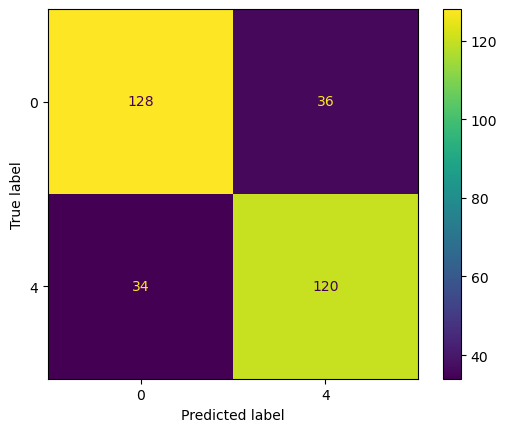

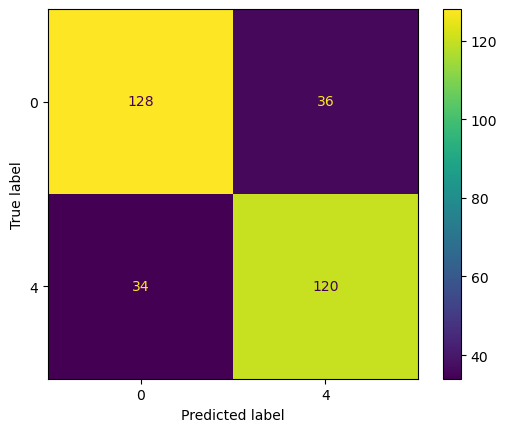

In [1081]:
# Put the path to the model folder in here
direc = r'Models\TFIDF_Logistic Regression_800000_06-13-2023--07-49-51'
corp = get_corpus(
    r'Data\testdata.csv',
    450, skippedlines=0
)

test_package(direc, corp, 'Logistic Regression')

In [ ]:
#get_tweets('wtfsicckko', includingReplies=False)

In [ ]:
# Use load_object to get vectorizer and model used for predictions.
#start('predict', ['I am happy!', 'I am sad.'], )